In [1]:
%matplotlib inline

In [2]:
# First run the following in the Google Earth Engine to obtain the data:

# // ----------------------------
# // 1. Define Iceland Geometry
# // ----------------------------
# var iceland = ee.Geometry.Rectangle([-25, 63, -12, 67]);

# // ----------------------------
# // 2. Load ERA5-Land Collection
# // ----------------------------
# var era5 = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR');

# // ----------------------------
# // 3. Define Water Year Range
# // ----------------------------
# var startYear = 1950;
# var endYear = 2023;  // last full water year is 2023–2024
# var waterYears = ee.List.sequence(startYear, endYear);

# // ----------------------------
# // 4. Variables by Aggregation Type
# // ----------------------------
# // Temperature is averaged
# var meanVars = ['temperature_2m'];

# // Precip and snowfall are summed
# var sumVars = ['total_precipitation_sum', 'snowfall_sum'];

# // Combined list for filtering
# var allVars = ee.List(meanVars).cat(sumVars);

# // ----------------------------
# // 5. Compute Water-Year Stats
# // ----------------------------
# var getWaterYearStats = function(year) {
#   year = ee.Number(year);
#   var start = ee.Date.fromYMD(year, 10, 1);
#   var end = start.advance(1, 'year');

#   // Filter image collection by date and variable
#   var filtered = era5.filterDate(start, end).select(allVars);

#   // Compute mean and sum composites
#   var meanImage = filtered.select(meanVars).mean();
#   var sumImage = filtered.select(sumVars).sum();

#   // Merge mean and sum images into one
#   var combinedImage = meanImage.addBands(sumImage)
#     .set('water_year', year)
#     .set('system:time_start', start.millis());

#   // Reduce to region stats over Iceland
#   var stats = combinedImage.reduceRegion({
#     reducer: ee.Reducer.mean(),
#     geometry: iceland,
#     scale: 10000,
#     maxPixels: 1e9
#   });

#   // Return as a feature
#   return ee.Feature(null, stats.set('water_year', year));
# };

# // ----------------------------
# // 6. Map Over All Water Years
# // ----------------------------
# var featureList = waterYears.map(getWaterYearStats);
# var featureCollection = ee.FeatureCollection(featureList);

# // ----------------------------
# // 7. Export as CSV to Google Drive
# // ----------------------------
# Export.table.toDrive({
#   collection: featureCollection,
#   description: 'ERA5Land_WaterYear_Stats_Iceland_2025.csv',
#   fileFormat: 'CSV'
# });

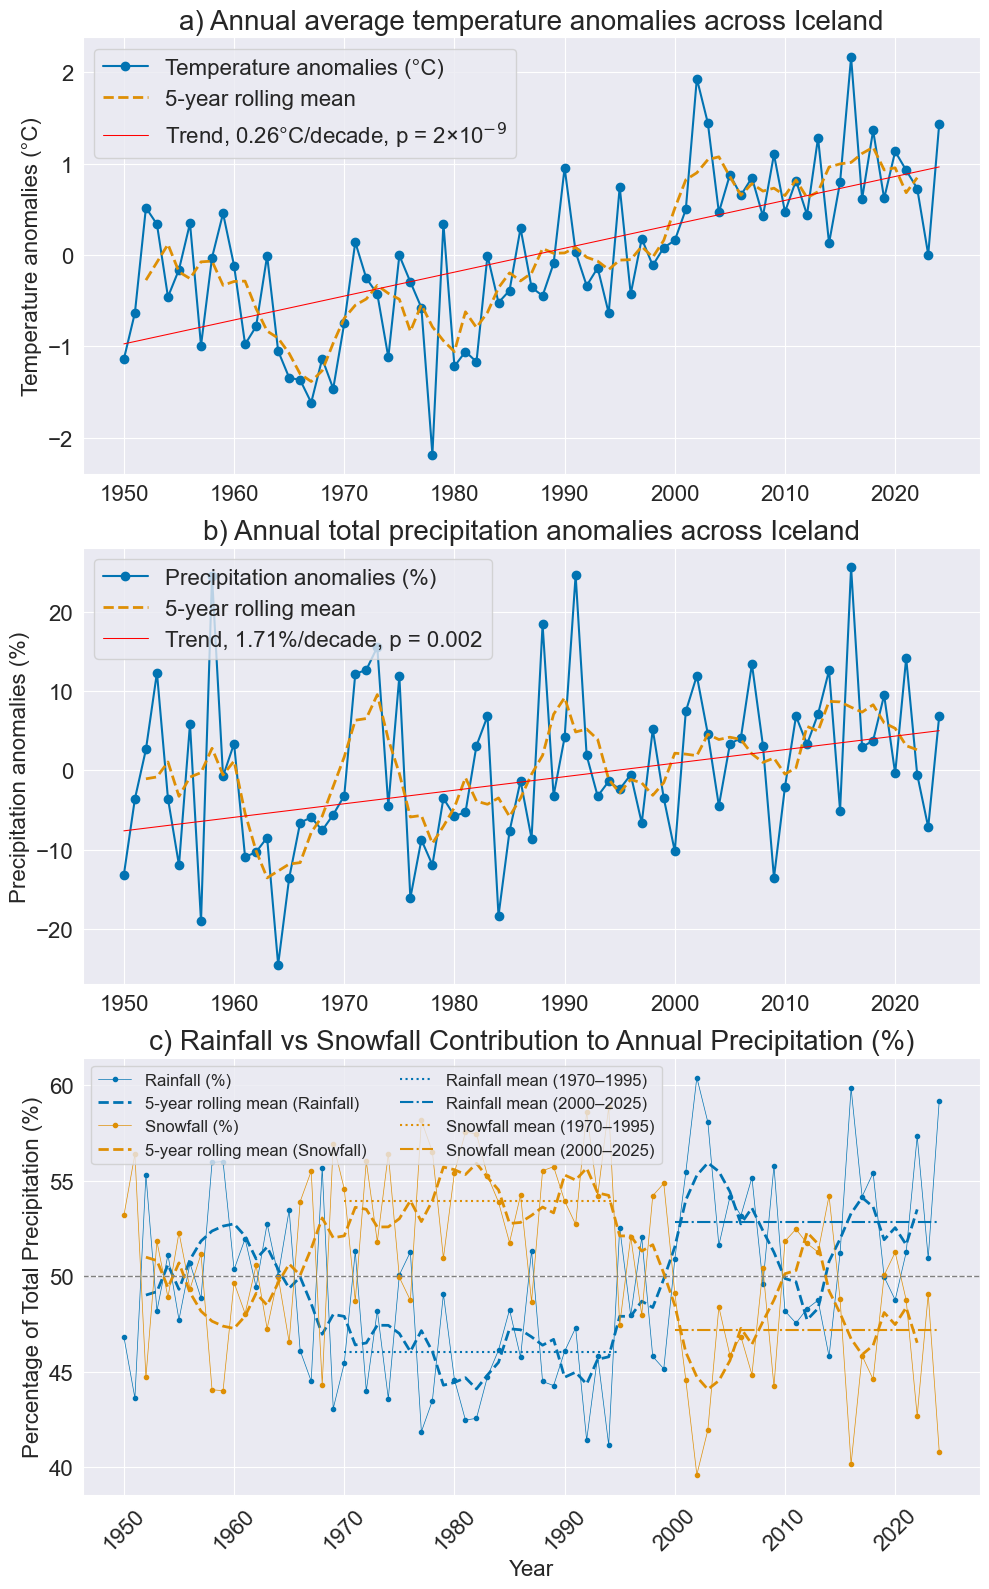

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import theilslopes
import pymannkendall as mk
from pathlib import Path
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("colorblind") 
rcParams['font.family'] = 'Arial'

# Load the dataset that was computed from Google Earth Engine
df = pd.read_csv(Path(r"ERA5Land_WaterYear_Stats_Iceland_2025.csv"))

# Clean and rename columns
df_clean = df[['water_year', 'temperature_2m', 'total_precipitation_sum', 'snowfall_sum']].copy()
df_clean.rename(columns={
    'temperature_2m': 'Temperature (K)',
    'total_precipitation_sum': 'Precipitation (m)',
    'snowfall_sum': 'Snowfall (m)'
}, inplace=True)

# Convert temperature from Kelvin to Celsius
df_clean['Temperature (°C)'] = df_clean['Temperature (K)'] - 273.15

# Compute rainfall
df_clean['Rainfall (m)'] = df_clean['Precipitation (m)'] - df_clean['Snowfall (m)']

# Set water_year as index
df_clean.set_index('water_year', inplace=True)

# --- Calculate deviations from the mean ---
mean_temp = df_clean['Temperature (°C)'].mean()
df_clean['Temperature Deviation (°C)'] = df_clean['Temperature (°C)'] - mean_temp

mean_precip = df_clean['Precipitation (m)'].mean()
mean_rainfall = df_clean['Rainfall (m)'].mean()
mean_snowfall = df_clean['Snowfall (m)'].mean()

df_clean['Precipitation Deviation (%)'] = (df_clean['Precipitation (m)'] - mean_precip) / mean_precip * 100
df_clean['Rainfall Deviation (%)'] = (df_clean['Rainfall (m)'] - mean_rainfall) / mean_rainfall * 100
df_clean['Snowfall Deviation (%)'] = (df_clean['Snowfall (m)'] - mean_snowfall) / mean_snowfall * 100

# --- Calculate 5-year rolling means ---
df_clean['5-Year Rolling Mean (Temp Deviation)'] = df_clean['Temperature Deviation (°C)'].rolling(window=5, center=True).mean()
df_clean['5-Year Rolling Mean (Precip Deviation)'] = df_clean['Precipitation Deviation (%)'].rolling(window=5, center=True).mean()
df_clean['5-Year Rolling Mean (Rainfall Deviation)'] = df_clean['Rainfall Deviation (%)'].rolling(window=5, center=True).mean()
df_clean['5-Year Rolling Mean (Snowfall Deviation)'] = df_clean['Snowfall Deviation (%)'].rolling(window=5, center=True).mean()

# --- Trend analysis ---
years = np.arange(len(df_clean))

# Theil-Sen slopes
slope_temp, intercept_temp, _, _ = theilslopes(df_clean['Temperature Deviation (°C)'].values, years)
slope_precip, intercept_precip, _, _ = theilslopes(df_clean['Precipitation Deviation (%)'].values, years)

# Mann-Kendall test
mk_result_temp = mk.original_test(df_clean['Temperature Deviation (°C)'].values, alpha=0.05)
mk_result_precip = mk.original_test(df_clean['Precipitation Deviation (%)'].values, alpha=0.05)

# --- Plotting ---
def format_p_value(p):
    if p < 1e-6:
        exponent = int(np.floor(np.log10(p)))
        base = p / (10 ** exponent)
        return f"{base:.0f}×10$^{{{exponent}}}$"
    elif p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"
        
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 16))
p_temp = mk_result_temp.p
label_temp = f"Trend, {slope_temp * 10:.2f}°C/decade, p = {format_p_value(p_temp)}"

p_precip = mk_result_precip.p
label_precip = f"Trend, {slope_precip * 10:.2f}%/decade, p = {format_p_value(p_precip)}"

# Temperature plot
ax1.plot(df_clean.index, df_clean['Temperature Deviation (°C)'], label='Temperature anomalies (°C)', marker='o')
ax1.plot(df_clean.index, df_clean['5-Year Rolling Mean (Temp Deviation)'], label='5-year rolling mean', ls='--', lw=2)
ax1.plot(df_clean.index, intercept_temp + slope_temp * years, color='red', lw=0.75, label=label_temp)
ax1.set_title('a) Annual average temperature anomalies across Iceland', fontsize=20)
ax1.set_ylabel('Temperature anomalies (°C)', fontsize=16)
ax1.legend(fontsize=16)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Precipitation plot
ax2.plot(df_clean.index, df_clean['Precipitation Deviation (%)'], label='Precipitation anomalies (%)', marker='o')
ax2.plot(df_clean.index, df_clean['5-Year Rolling Mean (Precip Deviation)'], label='5-year rolling mean', ls='--', lw=2)
ax2.plot(df_clean.index, intercept_precip + slope_precip * years, color='red', lw=0.75, label=label_precip)
ax2.set_title('b) Annual total precipitation anomalies across Iceland', fontsize=20)
ax2.set_ylabel('Precipitation anomalies (%)', fontsize=16)
ax2.legend(loc='upper left', fontsize=16)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=16)

# --- Compute rainfall and snowfall fractions ---
df_clean['Rainfall fraction (%)'] = 100 * df_clean['Rainfall (m)'] / df_clean['Precipitation (m)']
df_clean['Snowfall fraction (%)'] = 100 * df_clean['Snowfall (m)'] / df_clean['Precipitation (m)']

df_clean['5-Year Rolling Mean (Rainfall Fraction)'] = df_clean['Rainfall fraction (%)'].rolling(window=5, center=True).mean()
df_clean['5-Year Rolling Mean (Snowfall Fraction)'] = df_clean['Snowfall fraction (%)'].rolling(window=5, center=True).mean()

# --- Define periods for mean comparison ---
p1 = (df_clean.index >= 1970) & (df_clean.index <= 1995)
p2 = (df_clean.index >= 2000) & (df_clean.index <= 2025)

rain_mean_p1 = df_clean.loc[p1, 'Rainfall fraction (%)'].mean()
rain_mean_p2 = df_clean.loc[p2, 'Rainfall fraction (%)'].mean()
snow_mean_p1 = df_clean.loc[p1, 'Snowfall fraction (%)'].mean()
snow_mean_p2 = df_clean.loc[p2, 'Snowfall fraction (%)'].mean()

# --- Replace subfigure (c) with rainfall/snowfall fractions ---
ax3.clear()
ax3.plot(df_clean.index, df_clean['Rainfall fraction (%)'], label='Rainfall (%)', marker='o', color='C0', lw=0.5, markersize=3)
ax3.plot(df_clean.index, df_clean['5-Year Rolling Mean (Rainfall Fraction)'], label='5-year rolling mean (Rainfall)', ls='--', lw=2, color='C0')
ax3.plot(df_clean.index, df_clean['Snowfall fraction (%)'], label='Snowfall (%)', marker='o', color='C1', lw=0.5, markersize=3)
ax3.plot(df_clean.index, df_clean['5-Year Rolling Mean (Snowfall Fraction)'], label='5-year rolling mean (Snowfall)', ls='--', lw=2, color='C1')

# --- Add horizontal mean lines ---
ax3.hlines(rain_mean_p1, xmin=1970, xmax=1995, colors='C0', linestyles=':', linewidth=1.5, label='Rainfall mean (1970–1995)')
ax3.hlines(rain_mean_p2, xmin=2000, xmax=df_clean.index.max(), colors='C0', linestyles='-.', linewidth=1.5, label='Rainfall mean (2000–2025)')
ax3.hlines(snow_mean_p1, xmin=1970, xmax=1995, colors='C1', linestyles=':', linewidth=1.5, label='Snowfall mean (1970–1995)')
ax3.hlines(snow_mean_p2, xmin=2000, xmax=df_clean.index.max(), colors='C1', linestyles='-.', linewidth=1.5, label='Snowfall mean (2000–2025)')

# Optional: 50% reference line
ax3.axhline(50, color='gray', linestyle='--', linewidth=1)

ax3.set_title('c) Rainfall vs Snowfall Contribution to Annual Precipitation (%)', fontsize=20)
ax3.set_xlabel('Year', fontsize=16)
ax3.set_ylabel('Percentage of Total Precipitation (%)', fontsize=16)
ax3.legend(fontsize=12, ncol=2)
ax3.grid(True)
ax3.tick_params(axis='both', which='major', labelsize=16)

plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig(Path("Figure1_era5l_anomalies_snowf_rainf_perc.png"), dpi=300)
plt.savefig(Path("Figure1_era5l_anomalies_snowf_rainf_perc.pdf"), dpi=300)
# Show the figure
plt.show()


# Rainfall vs. snowfall

In [3]:
# --- Quantify rainfall vs snowfall contribution ---

# 1) Yearly fractions
df_clean['Rainfall fraction (%)'] = 100 * df_clean['Rainfall (m)'] / df_clean['Precipitation (m)']
df_clean['Snowfall fraction (%)'] = 100 * df_clean['Snowfall (m)'] / df_clean['Precipitation (m)']

# 2) Period means (edit years if you prefer slightly different windows)
yr_min, yr_max = int(df_clean.index.min()), int(df_clean.index.max())
p1 = (df_clean.index >= 1970) & (df_clean.index <= 1995)
p2 = (df_clean.index >= 2000) & (df_clean.index <= yr_max)

snow_p1 = df_clean.loc[p1, 'Snowfall fraction (%)'].mean()
snow_p2 = df_clean.loc[p2, 'Snowfall fraction (%)'].mean()
rain_p1 = df_clean.loc[p1, 'Rainfall fraction (%)'].mean()
rain_p2 = df_clean.loc[p2, 'Rainfall fraction (%)'].mean()

# 3) Trend in rainfall fraction (percentage points per decade)
x = np.arange(df_clean.shape[0])  # 0..N-1
slope_rainfrac, intercept_rainfrac, _, _ = theilslopes(df_clean['Rainfall fraction (%)'].values, x)
mk_rainfrac = mk.original_test(df_clean['Rainfall fraction (%)'].values, alpha=0.05)

# 4) Ready-to-paste sentence for the paper/caption
quant_sentence = (
    f"Snowfall contributed on average {snow_p1:.1f}% of annual precipitation during 1970–1995, "
    f"decreasing to {snow_p2:.1f}% during 2000–{yr_max}. Conversely, the rainfall fraction increased "
    f"from {rain_p1:.1f}% to {rain_p2:.1f}% over the same periods. The rainfall fraction exhibits a "
    f"trend of {slope_rainfrac*10:.2f} percentage points per decade (Mann–Kendall p = {format_p_value(mk_rainfrac.p)})."
)
print(quant_sentence)


Snowfall contributed on average 54.0% of annual precipitation during 1970–1995, decreasing to 47.2% during 2000–2024. Conversely, the rainfall fraction increased from 46.0% to 52.8% over the same periods. The rainfall fraction exhibits a trend of 0.58 percentage points per decade (Mann–Kendall p = 0.047).


# Trend between 2000 and 2025

In [4]:
# --- Subset data to water years 2000–2024 ---
subset = df_clean.loc[2000:2025].copy()

# Re-index years starting from 0 for trend calculation
subset_years = np.arange(len(subset))

# Theil-Sen slopes
slope_temp_sub, intercept_temp_sub, _, _ = theilslopes(subset['Temperature Deviation (°C)'].values, subset_years)
slope_precip_sub, intercept_precip_sub, _, _ = theilslopes(subset['Precipitation Deviation (%)'].values, subset_years)

# Mann-Kendall test
mk_result_temp_sub = mk.original_test(subset['Temperature Deviation (°C)'].values, alpha=0.05)
mk_result_precip_sub = mk.original_test(subset['Precipitation Deviation (%)'].values, alpha=0.05)

# Print trend results
print("2000–2025 Trends:")
print(f"Temperature trend: {slope_temp_sub * 10:.2f} °C/decade, p={mk_result_temp_sub.p:.3f}, trend={mk_result_temp_sub.trend}")
print(f"Precipitation trend: {slope_precip_sub * 10:.2f} %/decade, p={mk_result_precip_sub.p:.3f}, trend={mk_result_precip_sub.trend}")


2000–2025 Trends:
Temperature trend: 0.11 °C/decade, p=0.657, trend=no trend
Precipitation trend: 0.47 %/decade, p=0.907, trend=no trend
